In [0]:
import pandas as pd

In [2]:
data=pd.read_csv('ckg.csv')
data.head()

,text,ratingName,headline,keywords,source
0,GOP presidential candidate Ted Cruz ran a 'Net...,0,Ted Cruz Doesn’t Want to ‘Netflix and Chill’ w...,"politics, ted cruz",snopes
1,A woman managed to call 911 during a domestic ...,0,"In Case of Intruder, Should You Ask 911 for a ...","911 calls, domestic violence",snopes
2,The California Department of Public Health has...,0,Measles Parties,ASP Article,snopes
3,Michelle Obama gorged herself on an expensive ...,0,Michelle Obama and Room Service,"ASP Article, barack obama",snopes
4,A child injured his arm through extended weari...,1,Silly Bandz Danger,"ASP Article, Parental Nightmares",snopes


In [0]:
#droping the null values rom data
data.dropna(inplace=True)

In [0]:
#rearanging the data columns 
data=data[['text', 'headline', 'keywords', 'source', 'ratingName']]

In [9]:
ckg_x=data.iloc[:,0:-1]
ckg_y=data.iloc[:,-1]

#splitting x and y . y is to be predicted !!
print(ckg_x.shape)
print(ckg_y.shape)


(9336, 4)
(9336,)


In [10]:
#train test split to form test from megaset
from sklearn.model_selection import train_test_split

X_train_temp, ckg_test_x, y_train_temp, ckg_test_y = train_test_split(ckg_x,ckg_y,test_size=0.1,random_state=12)
print(X_train_temp.size)
print(ckg_test_x.size)

# mega_test_x : Final testing file with statements
# mega_test_y : Final testing file with ratings

ckg_train_x, ckg_dev_x, ckg_train_y, ckg_dev_y = train_test_split(X_train_temp,y_train_temp,test_size=ckg_test_x['text'].size,random_state=12)

print(ckg_train_x.size)
print(ckg_dev_x.size)


print(type(ckg_train_x))
print("Final size of train/dev/test : ",ckg_train_x['text'].size,"/",ckg_dev_x['text'].size,"/",ckg_test_x['text'].size)

33608
3736
29872
3736
<class 'pandas.core.frame.DataFrame'>
Final size of train/dev/test :  7468 / 934 / 934


In [0]:
import tensorflow
import pandas as pd
import keras 
import numpy as np

In [0]:
#use this tokenizer for data sent
from keras.preprocessing.text import Tokenizer
def tokenize(train_data,dev_data,test_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train_data)


  em_data_train = tokenizer.texts_to_sequences(train_data)
  em_data_dev= tokenizer.texts_to_sequences(dev_data)
  em_data_test=tokenizer.texts_to_sequences(test_data)
  #em_data_train=emeded training data
  #em_data_dev=emeded dev data

  vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
  print(vocab_size)


  return em_data_train,em_data_dev,em_data_test,vocab_size
#it reurn the tokenzied train and dev data and the vocab size of the data  

In [0]:
#padding the data to be sent 
from keras.preprocessing.sequence import pad_sequences

def padding(token_train_data,token_dev_data,token_test_data):
  maxlen=0
  for i in token_train_data:
    if(len(i)>maxlen):
        maxlen=len(i)
  print(maxlen)


  em_data_train_pad= pad_sequences(token_train_data, padding='post', maxlen=maxlen)
  em_data_dev_pad= pad_sequences(token_dev_data, padding='post', maxlen=maxlen)
  em_data_test_pad= pad_sequences(token_test_data, padding='post', maxlen=maxlen)

  return em_data_train_pad,em_data_dev_pad,em_data_test_pad,maxlen
#it reurn the padded data and the max len of the data

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [15]:
ckg_x.columns

Index(['text', 'headline', 'keywords', 'source'], dtype='object')

In [16]:
#sending the data to the tokenizer to tokenize the data
em_data_train_text,em_data_dev_text,em_data_test_text,text_vocabsize=tokenize(ckg_train_x.text,ckg_dev_x.text,ckg_test_x.text)
em_data_train_headline,em_data_dev_headline,em_data_test_headline,headline_vocabsize=tokenize(ckg_train_x.headline,ckg_dev_x.headline,ckg_test_x.headline)
em_data_train_keywords,em_data_dev_keywords,em_data_test_keywords,keywords_vocabsize=tokenize(ckg_train_x.keywords,ckg_dev_x.keywords,ckg_test_x.keywords)
em_data_train_source,em_data_dev_source,em_data_test_source,source_vocabsize=tokenize(ckg_train_x.source,ckg_dev_x.source,ckg_test_x.source)

17521
13380
4083
5


In [17]:
#sending the tokenized data to padding 
em_data_train_padtext,em_data_dev_padtext,em_data_test_padtext,text_maxlen=padding(em_data_train_text,em_data_dev_text,em_data_test_text)
em_data_train_padheadline,em_data_dev_padheadline,em_data_test_padheadline,headline_maxlen=padding(em_data_train_headline,em_data_dev_headline,em_data_test_headline)
em_data_train_padkeywords,em_data_dev_padkeywords,em_data_test_padkeywords,keywords_maxlen=padding(em_data_train_keywords,em_data_dev_keywords,em_data_test_keywords)
em_data_train_padsource,em_data_dev_padsource,em_data_test_padsource,source_maxlen=padding(em_data_train_source,em_data_dev_source,em_data_test_source)

123
38
24
1


In [18]:
#model building
#embeding 25


from keras.layers import Embedding
from keras.layers import concatenate
from keras.layers import Flatten
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import GlobalMaxPool1D


embedding_dim = 25
h1=int(2/3*100)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu')(all_d)
d2 = Dense(h2, activation='relu')(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model.summary()

66 44
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
______________________________________________________________________________________

Train on 7468 samples, validate on 934 samples
Epoch 1/50
7468/7468 [==============================] - 19s 3ms/step - loss: 0.5280 - acc: 0.7445 - val_loss: 0.4861 - val_acc: 0.7666
Epoch 2/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.3394 - acc: 0.8516 - val_loss: 0.5517 - val_acc: 0.7323
Epoch 3/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.1012 - acc: 0.9640 - val_loss: 0.8756 - val_acc: 0.7206
Epoch 4/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0186 - acc: 0.9952 - val_loss: 1.1748 - val_acc: 0.7270
Epoch 5/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0100 - acc: 0.9983 - val_loss: 1.1657 - val_acc: 0.6970
Epoch 6/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0069 - acc: 0.9983 - val_loss: 1.1878 - val_acc: 0.7131
Epoch 7/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0058 - acc: 0.9987 - val_loss: 1.2518 - val_acc: 0.7270
Epoch 8/

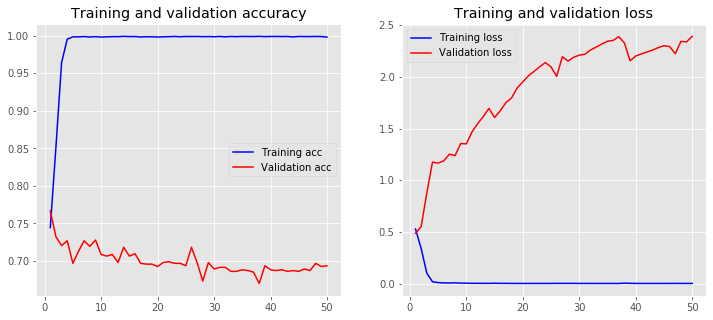

In [0]:
#model 1 for dev data
model.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h=model.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=50, batch_size=10,validation_data=({'text_in': em_data_dev_padtext, 'headline_in': em_data_dev_padheadline, 'keywords_in':em_data_dev_padkeywords,'source_in':em_data_dev_padsource},{'op': ckg_dev_y}))
plot_history(h)




Train on 7468 samples, validate on 934 samples
Epoch 1/50





7468/7468 [==============================] - 17s 2ms/step - loss: 0.5303 - acc: 0.7426 - val_loss: 0.4641 - val_acc: 0.7859
Epoch 2/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.3606 - acc: 0.8404 - val_loss: 0.4736 - val_acc: 0.7784
Epoch 3/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.1353 - acc: 0.9503 - val_loss: 0.6659 - val_acc: 0.7463
Epoch 4/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0240 - acc: 0.9936 - val_loss: 0.9399 - val_acc: 0.7238
Epoch 5/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0104 - acc: 0.9981 - val_loss: 0.9420 - val_acc: 0.7645
Epoch 6/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0097 - acc: 0.9976 - val_loss: 0.9306 - val_acc: 0.7762
Epoch 7/50
7468/7468 [==============================] - 16s 2ms/step - loss: 0.0057 - acc: 0.9983 - val_loss: 0.9991 - val_acc: 0.7398


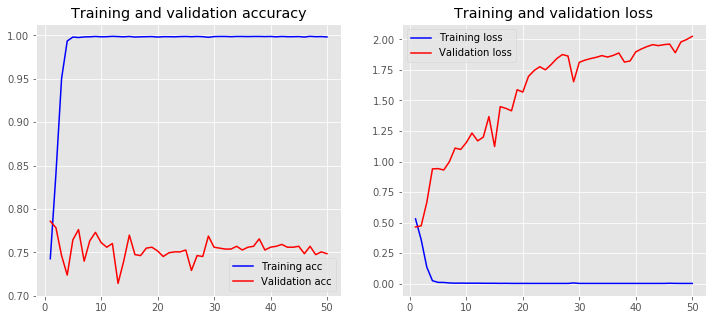

In [19]:
#model 1 for test data
model.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h=model.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=50, batch_size=10,validation_data=({'text_in': em_data_test_padtext, 'headline_in': em_data_test_padheadline, 'keywords_in':em_data_test_padkeywords,'source_in':em_data_test_padsource},{'op': ckg_test_y}))
plot_history(h)

In [0]:
#model 2

#model building
#embeding 50




embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu')(all_d)
d2 = Dense(h2, activation='relu')(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model1 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model1.summary()

133 88
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

Train on 7468 samples, validate on 934 samples
Epoch 1/15
7468/7468 [==============================] - 45s 6ms/step - loss: 0.5250 - acc: 0.7469 - val_loss: 0.4861 - val_acc: 0.7548
Epoch 2/15
7468/7468 [==============================] - 40s 5ms/step - loss: 0.3395 - acc: 0.8507 - val_loss: 0.5448 - val_acc: 0.7516
Epoch 3/15
7468/7468 [==============================] - 42s 6ms/step - loss: 0.0872 - acc: 0.9711 - val_loss: 0.7918 - val_acc: 0.7398
Epoch 4/15
7468/7468 [==============================] - 39s 5ms/step - loss: 0.0133 - acc: 0.9971 - val_loss: 1.1061 - val_acc: 0.7484
Epoch 5/15
7468/7468 [==============================] - 39s 5ms/step - loss: 0.0061 - acc: 0.9980 - val_loss: 1.3436 - val_acc: 0.7463
Epoch 6/15
7468/7468 [==============================] - 39s 5ms/step - loss: 0.0077 - acc: 0.9977 - val_loss: 1.1816 - val_acc: 0.7377
Epoch 7/15
7468/7468 [==============================] - 39s 5ms/step - loss: 0.0046 - acc: 0.9987 - val_loss: 1.2441 - val_acc: 0.7216
Epoch 8/

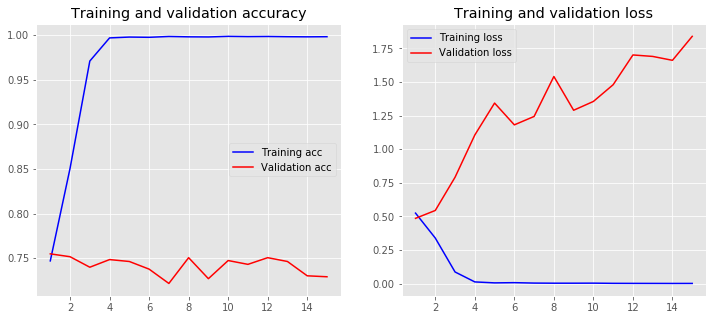

In [0]:
#model2 fitting and validating for dev data
model1.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h1=model1.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=15, batch_size=10,validation_data=({'text_in': em_data_dev_padtext, 'headline_in': em_data_dev_padheadline, 'keywords_in':em_data_dev_padkeywords,'source_in':em_data_dev_padsource},{'op': ckg_dev_y}))
plot_history(h1)

Train on 7468 samples, validate on 934 samples
Epoch 1/15
7468/7468 [==============================] - 45s 6ms/step - loss: 0.5249 - acc: 0.7479 - val_loss: 0.4884 - val_acc: 0.7591
Epoch 2/15
7468/7468 [==============================] - 38s 5ms/step - loss: 0.3187 - acc: 0.8614 - val_loss: 0.4826 - val_acc: 0.7752
Epoch 3/15
7468/7468 [==============================] - 39s 5ms/step - loss: 0.0744 - acc: 0.9750 - val_loss: 0.7682 - val_acc: 0.7334
Epoch 4/15
7468/7468 [==============================] - 40s 5ms/step - loss: 0.0128 - acc: 0.9964 - val_loss: 0.9461 - val_acc: 0.7430
Epoch 5/15
7468/7468 [==============================] - 40s 5ms/step - loss: 0.0061 - acc: 0.9984 - val_loss: 1.0449 - val_acc: 0.7334
Epoch 6/15
7468/7468 [==============================] - 40s 5ms/step - loss: 0.0072 - acc: 0.9980 - val_loss: 1.0292 - val_acc: 0.7709
Epoch 7/15
7468/7468 [==============================] - 40s 5ms/step - loss: 0.0045 - acc: 0.9985 - val_loss: 1.2024 - val_acc: 0.7559
Epoch 8/

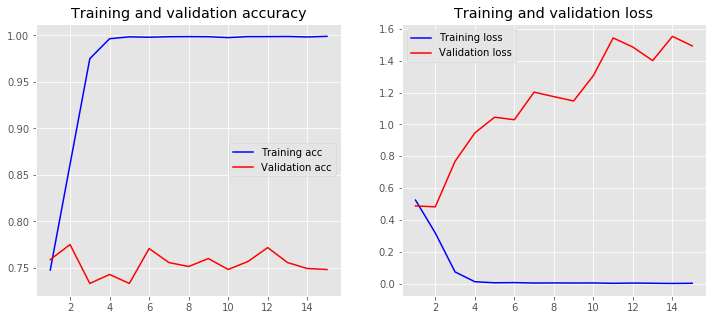

In [0]:
#model2 fitting and validating for dev data
model1.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h1=model1.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=15, batch_size=10,validation_data=({'text_in': em_data_test_padtext, 'headline_in': em_data_test_padheadline, 'keywords_in':em_data_test_padkeywords,'source_in':em_data_test_padsource},{'op': ckg_test_y}))
plot_history(h1)

In [0]:
#model 3

embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu')(all_d)
d2 = Dense(h2, activation='relu')(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model2 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model2.summary()

133 88
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

Train on 7468 samples, validate on 934 samples
Epoch 1/10
7468/7468 [==============================] - 86s 12ms/step - loss: 0.5205 - acc: 0.7424 - val_loss: 0.4833 - val_acc: 0.7645
Epoch 2/10
7468/7468 [==============================] - 78s 10ms/step - loss: 0.3020 - acc: 0.8731 - val_loss: 0.5533 - val_acc: 0.7537
Epoch 3/10
7468/7468 [==============================] - 80s 11ms/step - loss: 0.0686 - acc: 0.9752 - val_loss: 1.0398 - val_acc: 0.7516
Epoch 4/10
7468/7468 [==============================] - 80s 11ms/step - loss: 0.0127 - acc: 0.9957 - val_loss: 1.1758 - val_acc: 0.7366
Epoch 5/10
7468/7468 [==============================] - 78s 11ms/step - loss: 0.0068 - acc: 0.9985 - val_loss: 1.2219 - val_acc: 0.7281
Epoch 6/10
7468/7468 [==============================] - 77s 10ms/step - loss: 0.0042 - acc: 0.9984 - val_loss: 1.4497 - val_acc: 0.7463
Epoch 7/10
7468/7468 [==============================] - 76s 10ms/step - loss: 0.0054 - acc: 0.9976 - val_loss: 1.5492 - val_acc: 0.6981
E

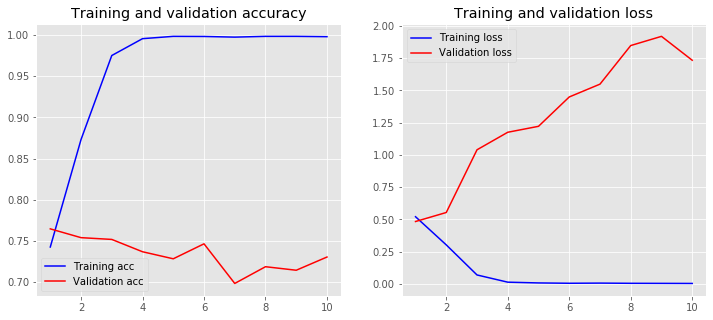

In [0]:
#model 3 fitting with dev data
model2.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h2=model2.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_dev_padtext, 'headline_in': em_data_dev_padheadline, 'keywords_in':em_data_dev_padkeywords,'source_in':em_data_dev_padsource},{'op': ckg_dev_y}))
plot_history(h2)

Train on 7468 samples, validate on 934 samples
Epoch 1/10
7468/7468 [==============================] - 87s 12ms/step - loss: 0.5196 - acc: 0.7442 - val_loss: 0.4488 - val_acc: 0.7912
Epoch 2/10
7468/7468 [==============================] - 81s 11ms/step - loss: 0.3162 - acc: 0.8591 - val_loss: 0.5156 - val_acc: 0.7837
Epoch 3/10
7468/7468 [==============================] - 83s 11ms/step - loss: 0.0761 - acc: 0.9750 - val_loss: 0.6895 - val_acc: 0.7452
Epoch 4/10
7468/7468 [==============================] - 83s 11ms/step - loss: 0.0124 - acc: 0.9969 - val_loss: 1.0749 - val_acc: 0.7677
Epoch 5/10
7468/7468 [==============================] - 84s 11ms/step - loss: 0.0065 - acc: 0.9979 - val_loss: 1.2471 - val_acc: 0.7216
Epoch 6/10
7468/7468 [==============================] - 84s 11ms/step - loss: 0.0059 - acc: 0.9980 - val_loss: 1.2927 - val_acc: 0.7570
Epoch 7/10
7468/7468 [==============================] - 83s 11ms/step - loss: 0.0046 - acc: 0.9984 - val_loss: 1.3237 - val_acc: 0.7452
E

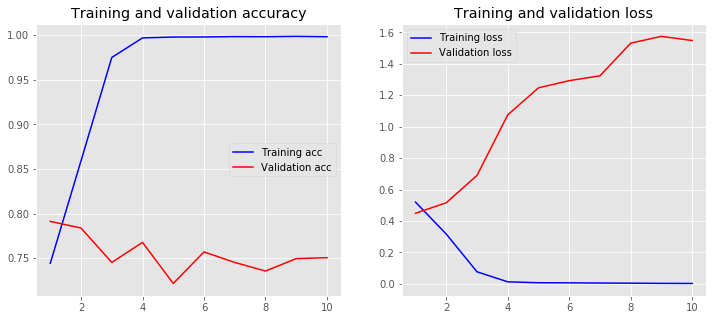

In [0]:
#model 3 fitting with test data
model2.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h2=model2.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_test_padtext, 'headline_in': em_data_test_padheadline, 'keywords_in':em_data_test_padkeywords,'source_in':em_data_test_padsource},{'op': ckg_test_y}))
plot_history(h2)

In [21]:
#model 3 is a best score so continue with that by adding regulraization
#with kernel and bias regularizer 
#more agressive

from keras.regularizers import l2
embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.001))(all_d)
d2 = Dense(h2, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.001))(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model3 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model3.summary()

133 88
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
_____________________________________________________________________________________

Train on 7468 samples, validate on 934 samples
Epoch 1/10
7468/7468 [==============================] - 62s 8ms/step - loss: 0.6437 - acc: 0.7358 - val_loss: 0.5394 - val_acc: 0.7302
Epoch 2/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.4817 - acc: 0.7836 - val_loss: 0.5269 - val_acc: 0.7505
Epoch 3/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.3408 - acc: 0.8899 - val_loss: 0.6001 - val_acc: 0.7452
Epoch 4/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.1894 - acc: 0.9642 - val_loss: 0.7762 - val_acc: 0.7452
Epoch 5/10
7468/7468 [==============================] - 60s 8ms/step - loss: 0.1068 - acc: 0.9909 - val_loss: 0.8442 - val_acc: 0.7398
Epoch 6/10
7468/7468 [==============================] - 60s 8ms/step - loss: 0.0718 - acc: 0.9967 - val_loss: 0.8599 - val_acc: 0.7398
Epoch 7/10
7468/7468 [==============================] - 60s 8ms/step - loss: 0.0536 - acc: 0.9979 - val_loss: 0.8653 - val_acc: 0.6991
Epoch 8/

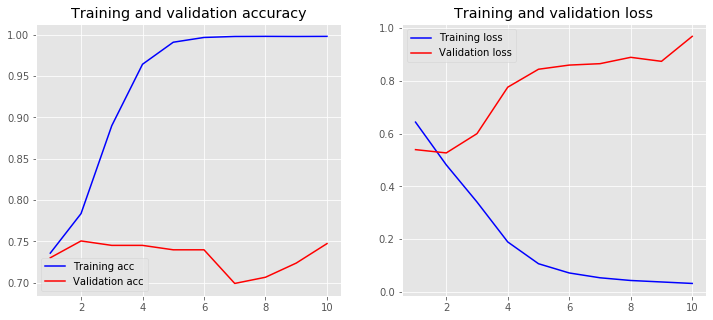

In [22]:
#model 3 fiting on dev data
model3.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h2=model3.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_dev_padtext, 'headline_in': em_data_dev_padheadline, 'keywords_in':em_data_dev_padkeywords,'source_in':em_data_dev_padsource},{'op': ckg_dev_y}))
plot_history(h2)

Train on 7468 samples, validate on 934 samples
Epoch 1/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.0282 - acc: 0.9977 - val_loss: 0.9118 - val_acc: 0.7570
Epoch 2/10
7468/7468 [==============================] - 59s 8ms/step - loss: 0.0241 - acc: 0.9983 - val_loss: 0.8698 - val_acc: 0.7291
Epoch 3/10
7468/7468 [==============================] - 59s 8ms/step - loss: 0.0209 - acc: 0.9981 - val_loss: 0.9576 - val_acc: 0.7463
Epoch 4/10
7468/7468 [==============================] - 59s 8ms/step - loss: 0.0180 - acc: 0.9985 - val_loss: 0.8326 - val_acc: 0.7452
Epoch 5/10
7468/7468 [==============================] - 60s 8ms/step - loss: 0.0179 - acc: 0.9984 - val_loss: 0.8504 - val_acc: 0.7430
Epoch 6/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.0165 - acc: 0.9983 - val_loss: 0.8422 - val_acc: 0.7559
Epoch 7/10
7468/7468 [==============================] - 60s 8ms/step - loss: 0.0163 - acc: 0.9983 - val_loss: 0.9058 - val_acc: 0.7088
Epoch 8/

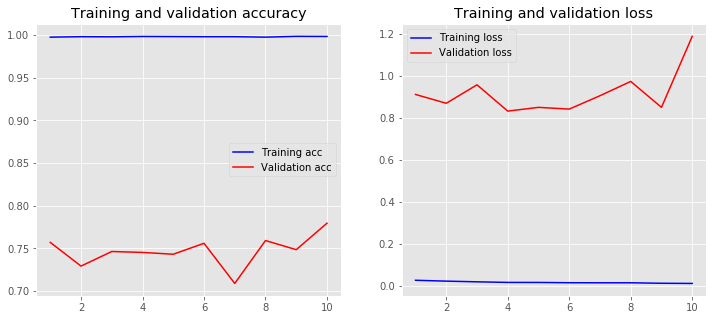

In [23]:
#model 3 fiting on dev data
model3.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h2=model3.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_test_padtext, 'headline_in': em_data_test_padheadline, 'keywords_in':em_data_test_padkeywords,'source_in':em_data_test_padsource},{'op': ckg_test_y}))
plot_history(h2)

In [40]:
embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu',kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(all_d)
d2 = Dense(h2, activation='relu',kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model4 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model4.summary()

133 88
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

Train on 7468 samples, validate on 934 samples
Epoch 1/10
7468/7468 [==============================] - 63s 8ms/step - loss: 0.5548 - acc: 0.7413 - val_loss: 0.5199 - val_acc: 0.7602
Epoch 2/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.3882 - acc: 0.8448 - val_loss: 0.5833 - val_acc: 0.7687
Epoch 3/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.1714 - acc: 0.9483 - val_loss: 0.8969 - val_acc: 0.7591
Epoch 4/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.0700 - acc: 0.9886 - val_loss: 1.0109 - val_acc: 0.7345
Epoch 5/10
7468/7468 [==============================] - 62s 8ms/step - loss: 0.0465 - acc: 0.9954 - val_loss: 0.9684 - val_acc: 0.7473
Epoch 6/10
7468/7468 [==============================] - 61s 8ms/step - loss: 0.0355 - acc: 0.9968 - val_loss: 0.9275 - val_acc: 0.7420
Epoch 7/10
7468/7468 [==============================] - 60s 8ms/step - loss: 0.0284 - acc: 0.9973 - val_loss: 0.9873 - val_acc: 0.7313
Epoch 8/

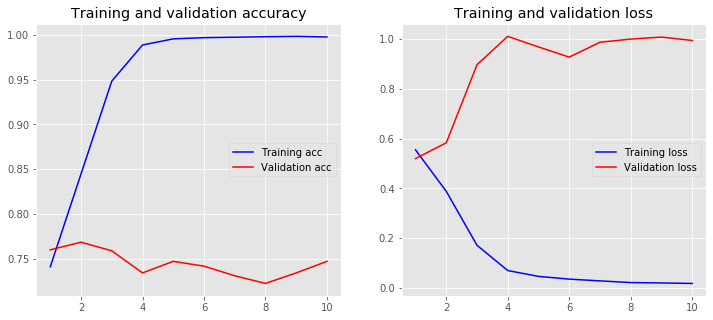

In [41]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h4=model4.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_dev_padtext, 'headline_in': em_data_dev_padheadline, 'keywords_in':em_data_dev_padkeywords,'source_in':em_data_dev_padsource},{'op': ckg_dev_y}))
plot_history(h4)

133 88
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

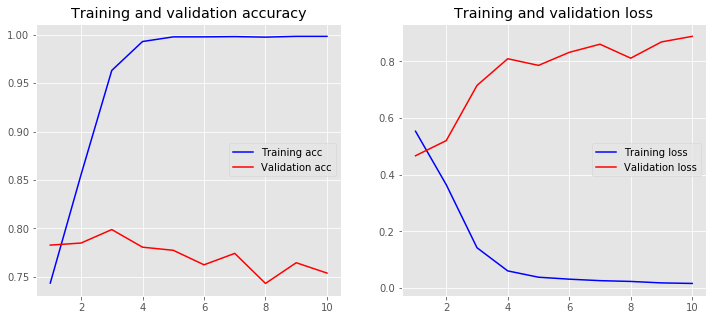

In [39]:
embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu',kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(all_d)
d2 = Dense(h2, activation='relu',kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model4 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model4.summary()
model4.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h4=model4.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_test_padtext, 'headline_in': em_data_test_padheadline, 'keywords_in':em_data_test_padkeywords,'source_in':em_data_test_padsource},{'op': ckg_test_y}))
plot_history(h4)

133 88
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

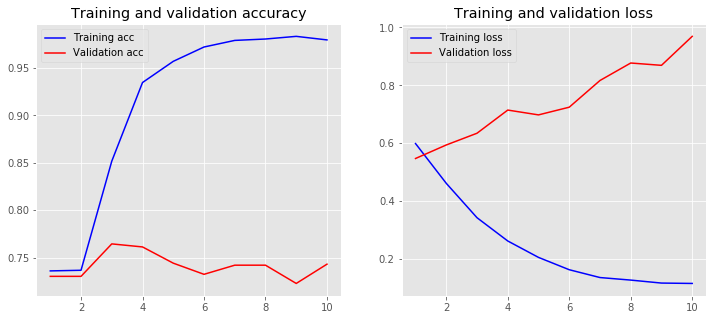

In [38]:
#all regularizer
#super agressive

embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu',activity_regularizer=l2(0.1),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(all_d)
d2 = Dense(h2, activation='relu',activity_regularizer=l2(0.1),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model5 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model5.summary()
model5.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h5=model5.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_dev_padtext, 'headline_in': em_data_dev_padheadline, 'keywords_in':em_data_dev_padkeywords,'source_in':em_data_dev_padsource},{'op': ckg_dev_y}))
plot_history(h5)

133 88
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

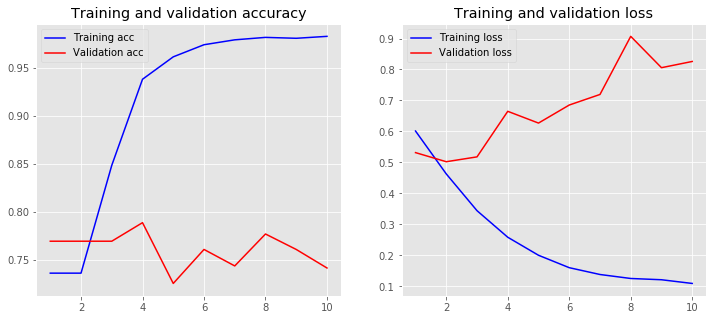

In [33]:
embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu',activity_regularizer=l2(0.1),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(all_d)
d2 = Dense(h2, activation='relu',activity_regularizer=l2(0.1),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model5 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model5.summary()
model5.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h5=model5.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_test_padtext, 'headline_in': em_data_test_padheadline, 'keywords_in':em_data_test_padkeywords,'source_in':em_data_test_padsource},{'op': ckg_test_y}))
plot_history(h5)

133 88
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

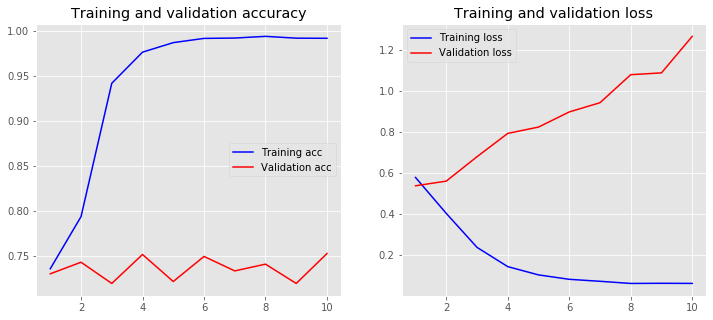

In [34]:
#all regularizer
#less agressive

embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu',activity_regularizer=l2(0.01),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(all_d)
d2 = Dense(h2, activation='relu',activity_regularizer=l2(0.01),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model5 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model5.summary()
model5.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h5=model5.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_dev_padtext, 'headline_in': em_data_dev_padheadline, 'keywords_in':em_data_dev_padkeywords,'source_in':em_data_dev_padsource},{'op': ckg_dev_y}))
plot_history(h5)

133 88
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_in (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
headline_in (InputLayer)        (None, 38)           0                                            
__________________________________________________________________________________________________
keywords_in (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
source_in (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________

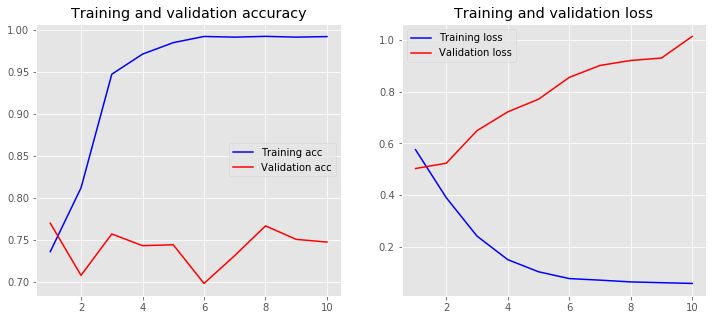

In [35]:

embedding_dim = 50
h1=int(2/3*200)
h2=int(2/3*h1)
print(h1,h2)

text_in = Input(shape=(123,), name='text_in')
headline_in = Input(shape=(38,), name='headline_in')
keywords_in = Input(shape=(24,), name='keywords_in')
source_in = Input(shape=(1,), name='source_in')

text_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=123)(text_in)
headline_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=38)(headline_in)
keywords_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=24)(keywords_in)
source_embed = Embedding(output_dim=embedding_dim, input_dim=17521, input_length=1)(source_in)

text_pool = GlobalMaxPool1D()(text_embed)
headline_pool = GlobalMaxPool1D()(headline_embed)
keywords_pool = GlobalMaxPool1D()(keywords_embed)
source_pool = GlobalMaxPool1D()(source_embed)

all_d = concatenate([text_pool, headline_pool,keywords_pool,source_pool])

d1 = Dense(h1, activation='relu',activity_regularizer=l2(0.01),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(all_d)
d2 = Dense(h2, activation='relu',activity_regularizer=l2(0.01),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(d1)

op = Dense(1, activation='sigmoid', name='op')(d2)




model5 = Model(inputs=[text_in,headline_in,keywords_in,source_in], outputs=[op])

model5.summary()
model5.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])
h5=model5.fit({'text_in': em_data_train_padtext, 'headline_in': em_data_train_padheadline, 'keywords_in':em_data_train_padkeywords,'source_in':em_data_train_padsource},{'op': ckg_train_y},
          epochs=10, batch_size=5,validation_data=({'text_in': em_data_test_padtext, 'headline_in': em_data_test_padheadline, 'keywords_in':em_data_test_padkeywords,'source_in':em_data_test_padsource},{'op': ckg_test_y}))
plot_history(h5)